In [1]:
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = np.loadtxt('../tp03/eur_usd_20120101_20120301.txt')

In [3]:
np.random.seed(1)
times = sorted(np.random.choice(np.arange(data.shape[0]), 20, replace=False))
for i, t in enumerate(times):
    print(f't{i:02d} = {datetime.fromtimestamp(data[t, 0])}')

every = 15 * 60
num_slices = 12
total_order = 12e6

t00 = 2012-01-16 08:18:35
t01 = 2012-01-16 08:19:34
t02 = 2012-01-18 09:19:56
t03 = 2012-01-25 17:55:22
t04 = 2012-01-25 19:14:33
t05 = 2012-01-26 13:09:02
t06 = 2012-01-29 18:00:08
t07 = 2012-02-01 07:32:18
t08 = 2012-02-01 18:29:38
t09 = 2012-02-02 04:10:39
t10 = 2012-02-03 13:15:14
t11 = 2012-02-03 15:08:38
t12 = 2012-02-03 15:14:40
t13 = 2012-02-03 15:33:39
t14 = 2012-02-09 11:33:03
t15 = 2012-02-09 13:24:54
t16 = 2012-02-10 09:33:23
t17 = 2012-02-10 13:37:53
t18 = 2012-02-24 08:04:47
t19 = 2012-02-24 17:51:44


# TWAP

In [4]:
def twap(start_time, total_order, num_slices, every):
    slice_size = total_order / num_slices
    orders = []
    t = start_time
    for i in range(num_slices):
        orders.append((t, slice_size, data[t, 2]))
        x = 0
        while data[t + x, 0] - data[t, 0] < every:
            x += 1
        t += x
    assert len(orders) == num_slices
    mean_price = sum([x[1] * x[2] for x in orders]) / total_order
    return mean_price, orders

In [5]:
twap_prices, asks = [], []
for i, t in enumerate(times):
    twap_price = twap(t, 12e6, 12, 15 * 60)[0]
    ask = data[t, 2]
    twap_prices.append(twap_price)
    asks.append(ask)
    print(f't{i:02d}: TWAP price = {twap_price:.3f}, ask(t{i:02d}) = {ask:.3f}')

t00: TWAP price = 1.267, ask(t00) = 1.267
t01: TWAP price = 1.266, ask(t01) = 1.267
t02: TWAP price = 1.281, ask(t02) = 1.279
t03: TWAP price = 1.308, ask(t03) = 1.304
t04: TWAP price = 1.309, ask(t04) = 1.305
t05: TWAP price = 1.316, ask(t05) = 1.315
t06: TWAP price = 1.323, ask(t06) = 1.324
t07: TWAP price = 1.309, ask(t07) = 1.304
t08: TWAP price = 1.316, ask(t08) = 1.318
t09: TWAP price = 1.317, ask(t09) = 1.318
t10: TWAP price = 1.312, ask(t10) = 1.316
t11: TWAP price = 1.312, ask(t11) = 1.309
t12: TWAP price = 1.312, ask(t12) = 1.311
t13: TWAP price = 1.312, ask(t13) = 1.311
t14: TWAP price = 1.327, ask(t14) = 1.327
t15: TWAP price = 1.329, ask(t15) = 1.329
t16: TWAP price = 1.325, ask(t16) = 1.328
t17: TWAP price = 1.318, ask(t17) = 1.318
t18: TWAP price = 1.339, ask(t18) = 1.338
t19: TWAP price = 1.347, ask(t19) = 1.347


# VWAP

In [6]:
def vwap(start_time, total_order, num_slices, every):
    s = data[start_time, 0] % 86400
    nb_ticks, _ = np.histogram(data[:, 0] % 86400, np.arange(s, s + every * (num_slices + 1), every))
    weights = nb_ticks / nb_ticks.sum()
    orders = []
    t = start_time
    for i in range(num_slices):
        slice_size = total_order * weights[i]
        orders.append((t, slice_size, data[t, 2]))
        x = 0
        while data[t + x, 0] - data[t, 0] < every:
            x += 1
        t += x
    assert len(orders) == num_slices
    mean_price = sum([x[1] * x[2] for x in orders]) / total_order
    return mean_price, orders

# Price based

In [7]:
def compute_directional_changes(ts, delta):
    mode = 'up'
    i_ext, x_ext = 0, ts[0]
    dc = []
    for i, x in enumerate(ts):
        if mode == 'up':
            if x < x_ext:
                i_ext, x_ext = i, x
            elif x - x_ext >= delta * x_ext:
                dc.append(('up', i, x, i_ext, x_ext))
                i_ext, x_ext = i, x
                mode = 'down'
        else:
            if x > x_ext:
                i_ext, x_ext = i, x
            elif x_ext - x >= delta * x_ext:
                dc.append(('down', i, x, i_ext, x_ext))
                i_ext, x_ext = i, x
                mode = 'up'
    return dc
        

In [8]:
def choose_delta(max_seconds, num_slices):
    delta = 0.001
    while True:
        dc = [x[1] for x in compute_directional_changes(data[:, 2], delta) if x[0] == 'down']
        if len(dc) / (data[-1, 0] - data[0, 0]) * max_seconds >= num_slices:
            break
        delta /= 2
    return delta

In [9]:
def price_based(start_time, total_order, num_slices, every, delta):
    dc = [x[1] for x in compute_directional_changes(data[:, 2], delta) if x[0] == 'down']
    for i, d in enumerate(dc):
        if d > start_time:
            break
    buy_times = dc[i : i + num_slices]
    order_duration = data[buy_times[-1], 0] - data[buy_times[0], 0]
    if order_duration > 3600 * 3:
        print(f"Warning, execution over {order_duration // 3600} hours and {order_duration % 3600} seconds")
    
    slice_size = total_order / num_slices
    orders = []
    for t in buy_times:
        orders.append((t, slice_size, data[t, 2]))
    assert len(orders) == num_slices
    mean_price = sum([x[1] * x[2] for x in orders]) / total_order
    return mean_price, orders

# Summary

In [10]:
#delta = choose_delta(max_seconds=3 * 3600, num_slices=num_slices)

asks, twap_prices, vwap_prices, dc_prices = [], [], [], []
for i, t in enumerate(times):
    ask = data[t, 2]
    tp = twap(t, total_order, num_slices, every)[0]
    vp = vwap(t, total_order, num_slices, every)[0]
    dcp = price_based(t, total_order, num_slices, every, delta=1e-5)[0]
    asks.append(ask)
    twap_prices.append(tp)
    vwap_prices.append(vp)
    dc_prices.append(dcp)
    print(f'ask(t{i:02d}) = {ask:.5f}, TWAP price = {tp:.5f}, VWAP price = {vp:.5f}, DC price = {dcp:.5f}')

ask(t00) = 1.26716, TWAP price = 1.26651, VWAP price = 1.26652, DC price = 1.26735
ask(t01) = 1.26731, TWAP price = 1.26646, VWAP price = 1.26647, DC price = 1.26740
ask(t02) = 1.27913, TWAP price = 1.28112, VWAP price = 1.28107, DC price = 1.27944
ask(t03) = 1.30438, TWAP price = 1.30782, VWAP price = 1.30764, DC price = 1.30464
ask(t04) = 1.30480, TWAP price = 1.30918, VWAP price = 1.30898, DC price = 1.30491
ask(t05) = 1.31459, TWAP price = 1.31589, VWAP price = 1.31592, DC price = 1.31458
ask(t06) = 1.32381, TWAP price = 1.32258, VWAP price = 1.32258, DC price = 1.32253
ask(t07) = 1.30416, TWAP price = 1.30891, VWAP price = 1.30909, DC price = 1.30408
ask(t08) = 1.31814, TWAP price = 1.31632, VWAP price = 1.31640, DC price = 1.31813
ask(t09) = 1.31836, TWAP price = 1.31730, VWAP price = 1.31730, DC price = 1.31813
ask(t10) = 1.31629, TWAP price = 1.31223, VWAP price = 1.31229, DC price = 1.31642
ask(t11) = 1.30919, TWAP price = 1.31168, VWAP price = 1.31154, DC price = 1.30926
ask(

In [11]:
mean_ask = np.mean(asks)
mean_twap = np.mean(twap_prices)
mean_vwap = np.mean(vwap_prices)
mean_dc = np.mean(dc_prices)
print(f'Mean ask: {mean_ask: .5f}, Mean TWAP: {mean_twap: .5f}, Mean VWAP: {mean_vwap: .5f}, Mean DC: {mean_dc: .5f}')
print(f'TWAP - ask: {mean_twap - mean_ask :.5f}')
print(f'VWAP - ask: {mean_vwap - mean_ask :.5f}')
print(f'DC - ask: {mean_dc - mean_ask :.5f}')

Mean ask:  1.31186, Mean TWAP:  1.31222, Mean VWAP:  1.31221, Mean DC:  1.31183
TWAP - ask: 0.00036
VWAP - ask: 0.00035
DC - ask: -0.00003


# Impact of Market Volatility

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../tp03/eur_usd_20120101_20120301.txt', sep=" ", names=["timestamp", "bid", "ask"])
df["mid"] = (df["bid"] + df["ask"]) / 2

In [13]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
df.set_index("timestamp", inplace=True)
df = df[df.index.year != 1970]

In [16]:
# Compute log returns and rolling volatility
df["returns"] = np.log(df["mid"]).diff()
df["volatility"] = df["returns"].rolling("30min").std()

np.random.seed(42)
random_times = np.random.choice(df.index, size=20, replace=False)

# low/high volatility
volatilities = df.loc[random_times, "volatility"]
median_vol = volatilities.median()
low_vol_intervals = volatilities[volatilities <= median_vol].index
high_vol_intervals = volatilities[volatilities > median_vol].index

def execute_strategy(start_time, total_order, num_slices, every, method, delta=0.0001):
    if method == "TWAP":
        return twap(start_time, total_order, num_slices, every)
    elif method == "VWAP":
        return vwap(start_time, total_order, num_slices, every)
    elif method == "Price Evolution":
        return price_based(start_time, total_order, num_slices, every, delta)
    else:
        raise ValueError("Unknown execution strategy")

# Execution prices for each strategy 
strategies = ["TWAP", "VWAP", "Price Evolution"]
execution_prices = {s: {"low_vol": [], "high_vol": []} for s in strategies}

for time in low_vol_intervals:
    start_time = np.searchsorted(data[:, 0], time.timestamp())  # Find closest index for timestamp
    for strategy in ["TWAP", "VWAP", "Price Evolution"]:
        mean_price, orders = execute_strategy(start_time, total_order=12e6, num_slices=12, every=30*60, method=strategy)
        execution_prices[strategy]["low_vol"].append(mean_price)

for time in high_vol_intervals:
    start_time = np.searchsorted(data[:, 0], time.timestamp())  
    for strategy in ["TWAP", "VWAP", "Price Evolution"]:
        mean_price, orders = execute_strategy(start_time, total_order=12e6, num_slices=12, every=30*60, method=strategy)
        execution_prices[strategy]["high_vol"].append(mean_price)

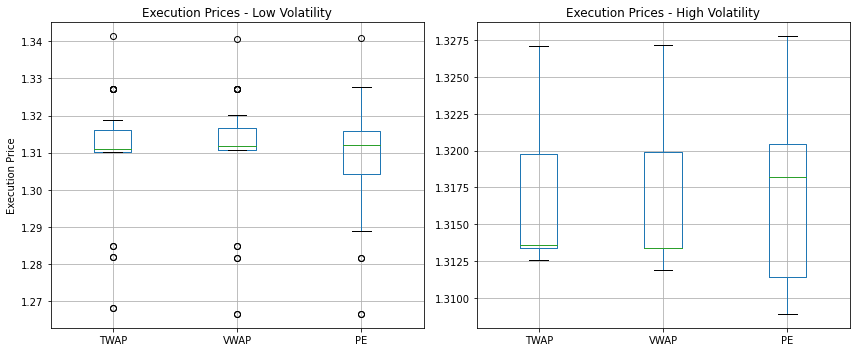

In [18]:
df_low = pd.DataFrame({
    "TWAP": pd.Series(execution_prices["TWAP"]["low_vol"]),
    "VWAP": pd.Series(execution_prices["VWAP"]["low_vol"]),
    "PE": pd.Series(execution_prices["Price Evolution"]["low_vol"])
})
df_high = pd.DataFrame({
    "TWAP": pd.Series(execution_prices["TWAP"]["high_vol"]),
    "VWAP": pd.Series(execution_prices["VWAP"]["high_vol"]),
    "PE": pd.Series(execution_prices["Price Evolution"]["high_vol"])
})

# Plot boxplots separately
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
df_low.boxplot()
plt.title("Execution Prices - Low Volatility")
plt.ylabel("Execution Price")

plt.subplot(1,2,2)
df_high.boxplot()
plt.title("Execution Prices - High Volatility")

plt.tight_layout()
plt.show()
